**Loading Dependencies:**

In [160]:
# pwd
import os
os.getcwd( )
os.chdir('C://Users//vinay//Desktop//files//3. CSE4020 ML//Project//codes') 

In [106]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split,GridSearchCV
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from tqdm import tqdm
import re
import collections
from scipy.sparse import csr_matrix
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from wordcloud import WordCloud, STOPWORDS

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vinay\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\vinay\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


**Loading Training Data**

In [107]:
# Loading the dataset
train_data=pd.read_csv("train.csv")
train_data.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


    *   Train-id: id of the product (numerical)
    *   Name: the title of the listing.(textual)
    *   item_condition_id - the condition of the items provided by the seller (numerical)
    *   category_name - category of the listing(categorical)
    *   brand_name - brand of the product (categorical)
    *   price - the price that the item was sold for. (target)
    *   shipping - 1 if shipping fee is paid by seller and 0 by buyer(binary)
    *   item_description - the full description of the item.(textual)

In [108]:
train_data.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

In [109]:
print("Number of Nan values in category_name: {}%".format((train_data['category_name'].isnull().sum()/train_data.shape[0])*100))
print("Number of Nan values in brand_name: {}%".format((train_data['brand_name'].isnull().sum()/train_data.shape[0])*100))
print("Number of Nan values in item_description: {}%".format((train_data['item_description'].isnull().sum()/train_data.shape[0])*100))

Number of Nan values in category_name: 0.42676901388500105%
Number of Nan values in brand_name: 42.675687251902986%
Number of Nan values in item_description: 0.0002698081326916397%


**Splitting the data**

In [110]:
# Removing the price which is less than 0.
train_data = train_data[train_data['price'] > 0].reset_index(drop=True)
train_data,cv_data=train_test_split(train_data,test_size=0.1,random_state=42)
print(train_data.shape)
print(cv_data.shape)

(1333494, 8)
(148167, 8)


In [111]:
train=train_data.copy()
val=cv_data.copy()

**Observations:**


*   We can see that our data consists of Null values.
*   As a formost step we need to fill the Null values with the most prominent values.
*   We can see the category name consists of three subcategories in each row as a preprocessing step let's make them into three different categories and filling the Nan values with empty string values.

**Handling Nan Values:**

In [112]:
def handle_category(data):
  """this function splits the category_name into further three sub_categories."""
  cat1=[]
  cat2=[]
  cat3=[]
  i=0
  for row in data:
    try:
      categories=row.split('/')
    except:
      categories=['','','']
    cat1.append(categories[0])
    cat2.append(categories[1])
    cat3.append(categories[2])
    i+=1
  return cat1,cat2,cat3

In [113]:
c1,c2,c3=handle_category(train_data['category_name'])
train_data['sub_category1']=c1
train_data['sub_category2']=c2
train_data['sub_category3']=c3
c1,c2,c3=handle_category(cv_data['category_name'])
cv_data['sub_category1']=c1
cv_data['sub_category2']=c2
cv_data['sub_category3']=c3

In [114]:
train_data['item_description'].fillna(value='No description given',inplace=True)
train_data['brand_name'].fillna(value='Not known',inplace=True)
train_data.isnull().sum()

train_id                0
name                    0
item_condition_id       0
category_name        5661
brand_name              0
price                   0
shipping                0
item_description        0
sub_category1           0
sub_category2           0
sub_category3           0
dtype: int64

In [115]:
cv_data['item_description'].fillna(value='No description given',inplace=True)
cv_data['brand_name'].fillna(value='Not known',inplace=True)
cv_data.isnull().sum()

train_id               0
name                   0
item_condition_id      0
category_name        653
brand_name             0
price                  0
shipping               0
item_description       0
sub_category1          0
sub_category2          0
sub_category3          0
dtype: int64

**Exploratory Data Analysis:**

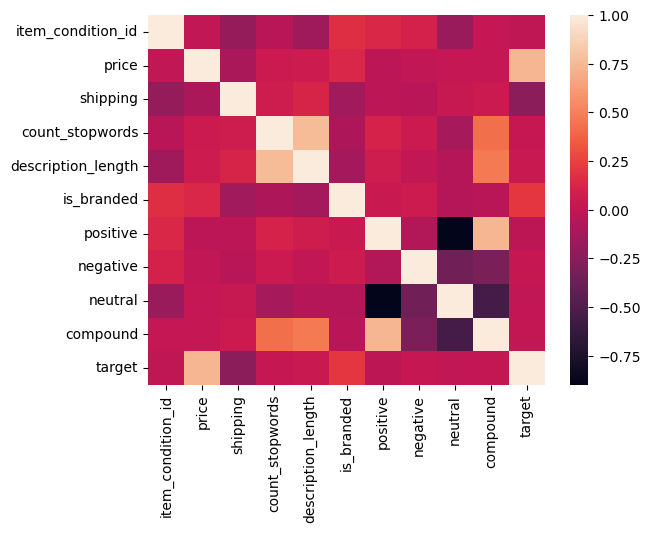

In [163]:
import seaborn as sns
sns.heatmap(train_data.corr())
plt.show()

**sub_category1:**

Number of Unique Category1: 11


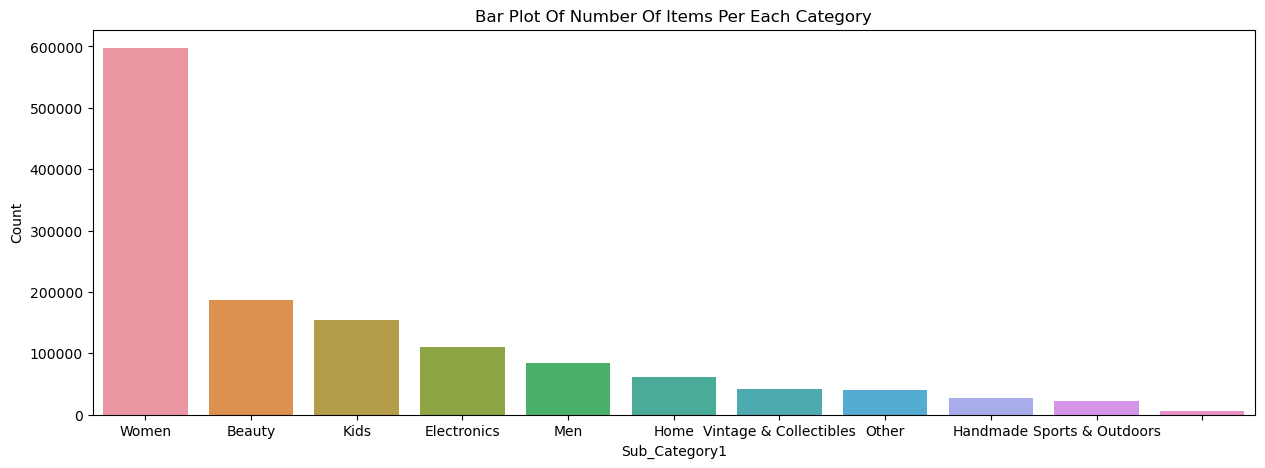

In [116]:
count=train_data['sub_category1'].value_counts()
print("Number of Unique Category1: {}".format(len(count)))
plt.figure(figsize=(15,5))
sns.barplot(count.index,count)
plt.title("Bar Plot Of Number Of Items Per Each Category")
plt.xlabel('Sub_Category1')
plt.ylabel('Count')
plt.show()

**Observations:**


    *   We can see that the top three main categories of the products are women,Beauty and kids.
    *   Nearly 6 lakhs of products have women as main category.



**sub_category2:**

Number Of Unique Category2: 114


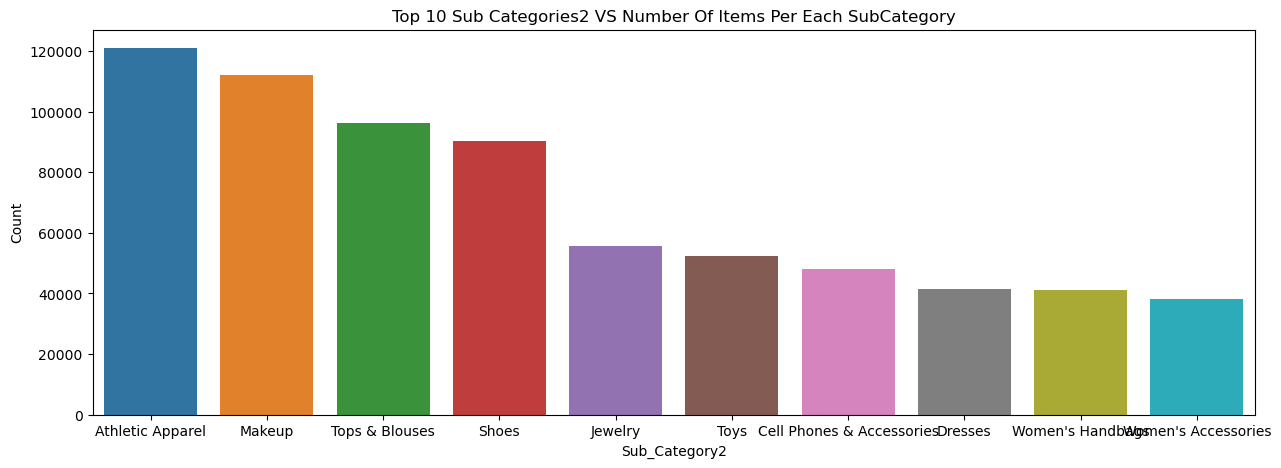

In [117]:
count=train_data['sub_category2'].value_counts()
print("Number Of Unique Category2: {}".format(len(count)))
plt.figure(figsize=(15,5))
sns.barplot(count.index[:10],count[:10])
plt.xlabel('Sub_Category2')
plt.ylabel('Count')
plt.title("Top 10 Sub Categories2 VS Number Of Items Per Each SubCategory")
plt.show()

**Observations:**


    *   Nearly 12 lakhs of products are Athletic Apparel
    *   Athletic Apparel, Makeup and Tops&Blouses are the top three repeating sub categories.



**sub_category3:**

Number Of Unique Category3: 869


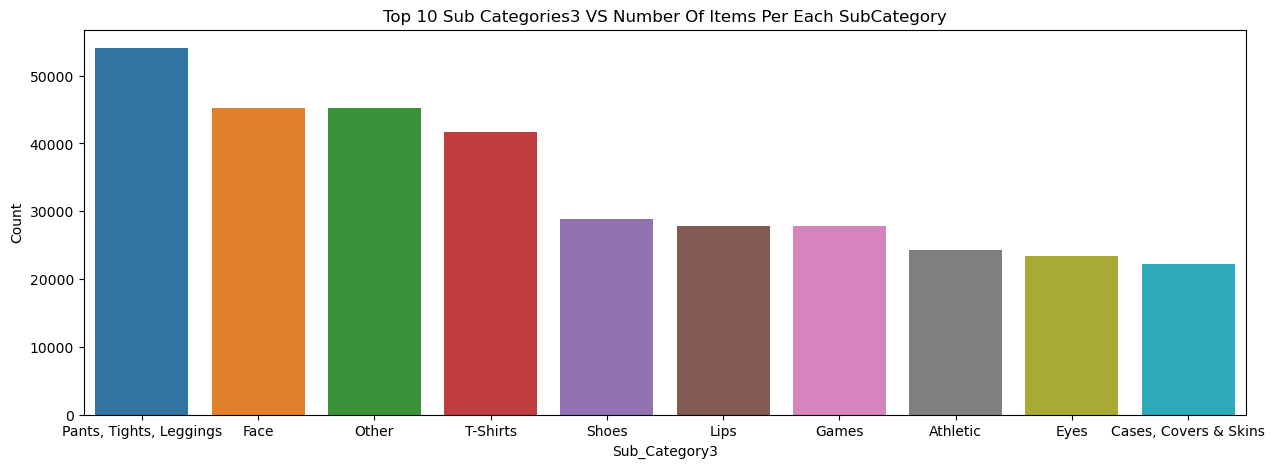

In [118]:
count=train_data['sub_category3'].value_counts()
print("Number Of Unique Category3: {}".format(len(count)))
plt.figure(figsize=(15,5))
sns.barplot(count.index[:10],count[:10])
plt.xlabel('Sub_Category3')
plt.ylabel('Count')
plt.title("Top 10 Sub Categories3 VS Number Of Items Per Each SubCategory")
plt.show()

**Observations:**


    *   Pants,Tights,Leggings ,Face and Other categories are the top three repeating things in subcategory level3.
    *   It is clear that the dataset contains products related to womens the most like cosmotics, dresses and some related accessories of womens.


**Brand_names:**

Number of Unique Brands: 4674


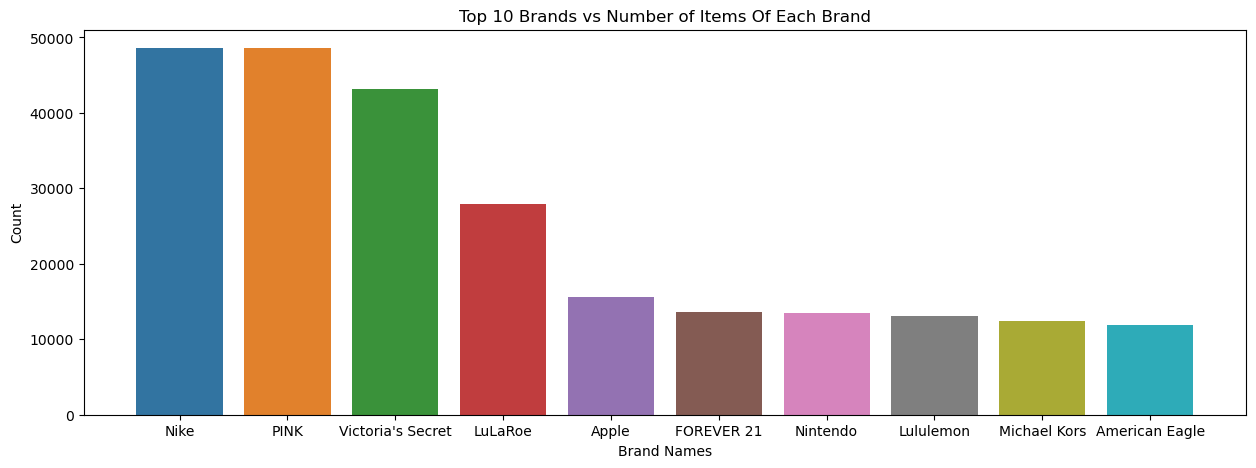

In [119]:
unique_brands=train_data['brand_name'].value_counts()
print("Number of Unique Brands: {}".format(len(unique_brands)))
plt.figure(figsize=(15,5))
sns.barplot(unique_brands.index[1:11],unique_brands[1:11])
plt.title('Top 10 Brands vs Number of Items Of Each Brand')
plt.xlabel('Brand Names')
plt.ylabel('Count')
plt.plot()
plt.show()

**Observations:**


    *   Nike and PINK are the two brands which are most common brands of the products in equal proportion. Victoria's Secret is to the next in the competition.
    *   As we already know that most of the products doesn't have brand in the data then obviously unknown brand will be in the top count among all these brands. But as a visualization part i skipped that one.



**Item_condition_id:**

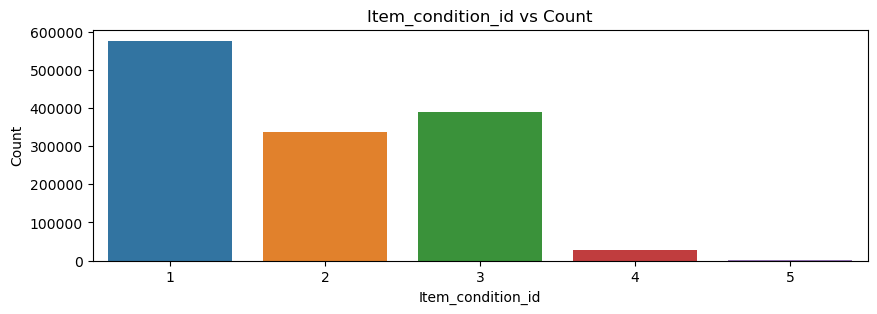

In [120]:
count=train_data['item_condition_id'].value_counts()
plt.figure(figsize=(10,3))
sns.barplot(count.index[:10],count[:10])
plt.title('Item_condition_id vs Count')
plt.xlabel('Item_condition_id')
plt.ylabel('Count')
plt.show()

**Observations:**


    *   Item_condition_id with 1 as a id is the most repeating one in the products.
    *   Nearly 60 lakhs of products have condition_id 1.
    *   item_condition_id with 5 as a id is the least repeating one.



**Shipping:**

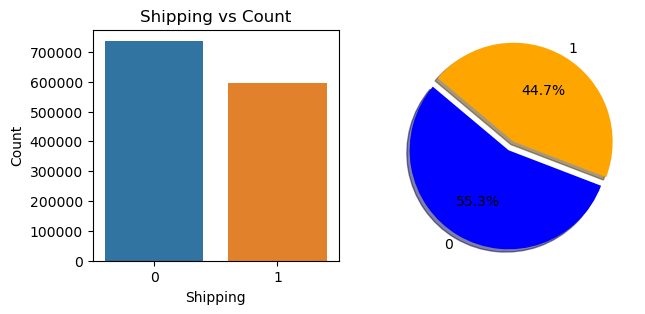

In [121]:
count=train_data['shipping'].value_counts()
plt.figure(figsize=(7,3))
plt.subplot(1,2,1)
sns.barplot(count.index,count)
plt.xlabel('Shipping')
plt.ylabel('Count')
plt.title('Shipping vs Count')
plt.subplot(1,2,2)
labels = ['0','1']
sizes = count
colors = ['blue','orange']
explode = (0.1, 0)  # explode 1st slice
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

**Observations:**


*   We can see that most of the shipping fee is paid by buyers only.(55.3%)
*   44.7% of the product's whose shipping fee is paid by sellers.



**Price:**

In [122]:
train_data['price'].describe()

count    1.333494e+06
mean     2.675457e+01
std      3.866316e+01
min      3.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

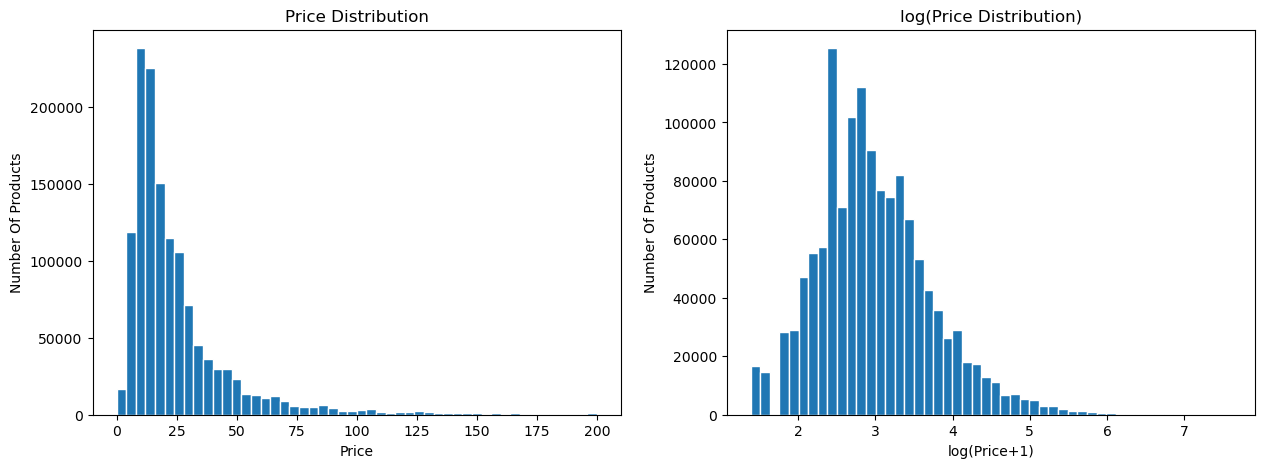

In [123]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(train_data['price'],bins=50,range=[0,200],edgecolor='white')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel("Number Of Products")
plt.subplot(1,2,2)
log_price=[np.log(i+1) for i in train_data['price']]
plt.hist(np.log(train_data['price']+1),bins=50,edgecolor='white')
plt.title("log(Price Distribution)")
plt.xlabel("log(Price+1)")
plt.ylabel("Number Of Products")
plt.show()

**Observations:**

    *   In the left graph we can see a tailedness in the curve whose values are deprecating towards 0.
    *   Hence we take log(price+1) instead of price.

**Feature Engineering:**

*   Let's Introduce New features in the data
*   For textual data we can perform following feature engineering:


     1.  Number of stopwords
     2.  count of the words
     3.  Presence of Numerical data
     4.  Sentiment score Analysis.





In [124]:
stopwords=set(stopwords.words('english'))

In [125]:
def stopwords_count(data):
  """this function counts the number of stopwords in each of the item_description"""
  count_stopwords=[]
  for i in tqdm(data['item_description']):
    count=0
    for j in i.split(' '):
      if j in stopwords: count+=1  #finding if the word is present in the nltk stopwords or not
    count_stopwords.append(count)
  return count_stopwords

In [126]:
train_data['count_stopwords']=stopwords_count(train_data)
cv_data['count_stopwords']=stopwords_count(cv_data)

100%|██████████████████████████████████████████████████████████████████████| 148167/148167 [00:00<00:00, 296854.63it/s]


In [127]:
train_data['count_stopwords'].describe()

count    1.333494e+06
mean     5.982603e+00
std      9.063958e+00
min      0.000000e+00
25%      0.000000e+00
50%      3.000000e+00
75%      8.000000e+00
max      1.180000e+02
Name: count_stopwords, dtype: float64

Text Preprocessing:

In [128]:
def decontracted(phrase):
    """this function removies shorthands for the textual data..."""
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

**Removing StopWords**


1.   Usually text data contains stopwords which are no more useful as features as they are just to make a complete meaning in the english language
2.   Hence it is necessary to remove stopwords which are not useful for the regression model. 
3. One way to do that is by using **nltk** (Natural Language Tool Kit)



In [129]:
def text_preprocessing(data):
  """this function performs preprocessing the item_description """
  preprocessed_total = []
  for sentance in tqdm(data['item_description'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)  #removing stop words
    preprocessed_total.append(sent.lower().strip())
  return preprocessed_total

In [130]:
train_data['item_description']=text_preprocessing(train_data)
cv_data['item_description']=text_preprocessing(cv_data)

100%|███████████████████████████████████████████████████████████████████████| 148167/148167 [00:03<00:00, 44508.17it/s]


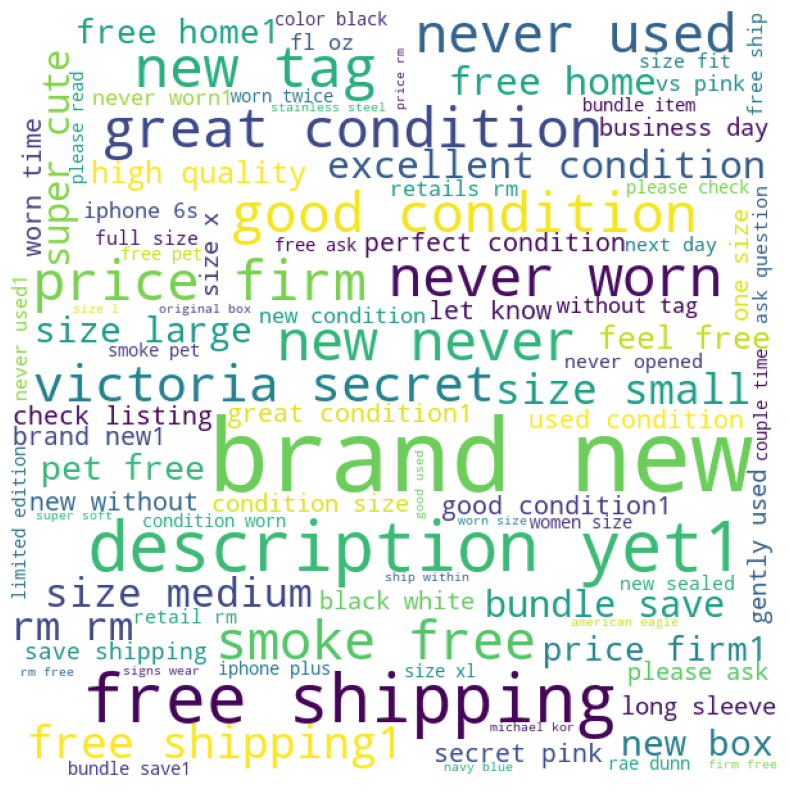

In [131]:
stopwords=set(STOPWORDS)
word_cloud = WordCloud(width = 600, height = 600,background_color ='white', stopwords=stopwords,min_font_size = 10).generate("1 ".join(train_data['item_description']))
plt.figure(figsize = (15, 10))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

**Observations:**


    *   From the above wordcloud (brand,new,free,shipping,description,yet) are the most common words in the item description.
    *   Sellers are using new,free,shipping,description words to advertise their products to the buyers.



In [132]:
word_count={}
for sentence in tqdm(train_data['item_description']):
    for word in sentence.split(' '):
        if len(word)>=3:  #taking words which are of length>=3
            if word not in word_count:
                word_count[word]=1  #if word not present in dict assigning it to 1
            else:
                word_count[word]+=1 #else incrementing it by 1

100%|████████████████████████████████████████████████████████████████████| 1333494/1333494 [00:09<00:00, 134632.80it/s]


In [133]:
n_print=25
word_counter = collections.Counter(word_count)
words=[]
counter=[]
for word, count in word_counter.most_common(n_print):
    words.append(word)
    counter.append(count)

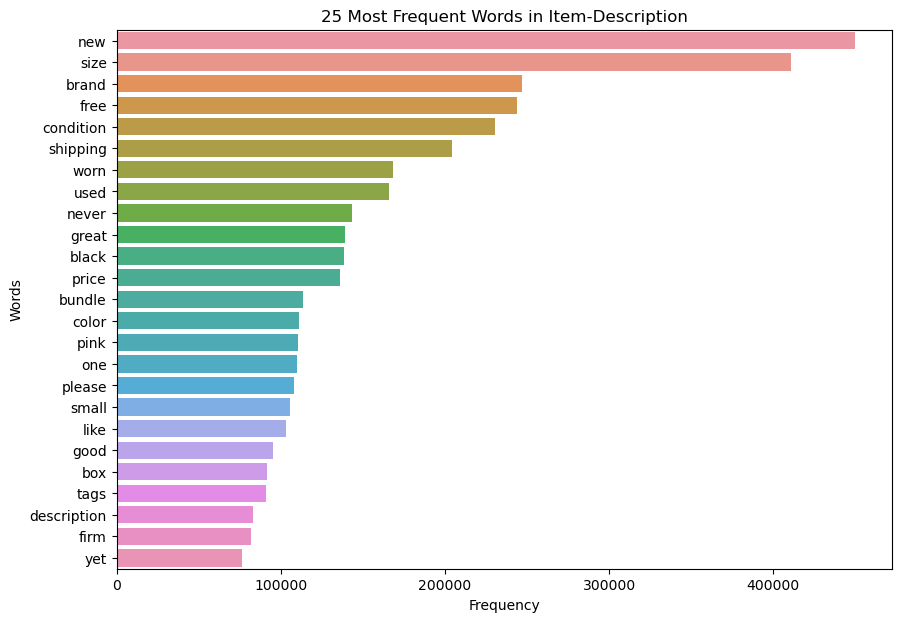

In [134]:
plt.figure(figsize=(10,7))
sns.barplot(counter,words)
plt.title("25 Most Frequent Words in Item-Description")
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

**Observations:**


    *   new and size are the two top words that are repeating in the item description.
    *   Nearly 45 lakhs of products use new in their item description.



**Feature Engineering - 2**

*   As a Hack let's take count of number of words in the item_description.
*   As the next feature engineering task let's use count of words,and sentiment score analysis as the new features in our task.

In [135]:
def description_length(data):
  """this function finds the length of the description basing on spaces in the statement"""
  description_length=[]
  for i in data['item_description']:
    description_length.append(len(i.split(' '))) #splitting statement using spaces and finding length of it
  return description_length

In [136]:
print("processing item_description in train_data...")
train_data['description_length']=description_length(train_data)
cv_data['description_length']=description_length(cv_data)
print(train_data.iloc[100]['item_description'],train_data.iloc[100]['description_length'])

processing item_description in train_data...
two size 24 cowgirl tuff new jeans 7


In [137]:
train_data['description_length'].describe()

count    1.333494e+06
mean     1.803721e+01
std      2.065138e+01
min      1.000000e+00
25%      6.000000e+00
50%      1.100000e+01
75%      2.100000e+01
max      2.510000e+02
Name: description_length, dtype: float64

**Feature Engineering -3 :**

Is_branded:


1.   We cam see that most of the products don't have brand.That can be used as a feature for our data.
2.   We know that a product with different brands vary with their price. This is based on the company which it is producing.
3.   A good brand will have a good price compared to the same product of different brand.
4.   Therefore two similar products with different brands(known brand,unknown brand) can help us to know the price of the product.
5.   If it's a branded product then it has a value of 1 else it has a value of 0.



In [138]:
def branded(data):
   """this function assigns a value 1 if a product has brand_name else 0"""
   is_branded=[]
   for i in data['brand_name']:
      if i=='Not known': is_branded.append(0) #if it is a Nan value i.e.. unknown brand make it as 0.
      else: is_branded.append(1)
   return is_branded
train_data['is_branded']=branded(train_data)
cv_data['is_branded']=branded(cv_data)

**Feature Engineering - 4**

**Sentiment Score Analysis:**

    1.   Sentiment Score Analysis is often used as a feature engineering hack dealing with textual data.
    2.   It tries to identify and extract opinions within a given text.
    3.   Sentiment Analysis is a tricky part but it comes into handy by using nltk in python.
    3.   It is going to return four values: positive, negative, neutral, and compound.

==>   How Sentiment Score Analysis helps us in our task??
*   More often a positive description product may charge high. similarly a negative description product may charge low. 
*   That means their is some correlation with the description and the price(target value) in our data and it signs a good vibes for our task.





In [139]:
def sentiment_analysis(data):
   """this function performs sentiment score analysis of each datapoint"""
   sentiment_score = SentimentIntensityAnalyzer()
   sentiment = []
   for sentence in tqdm(data):
       sentiment.append(sentiment_score.polarity_scores(sentence))
   return sentiment

In [140]:
training_sentiment_score=sentiment_analysis(train_data['item_description']) 
cv_sentiment_score=sentiment_analysis(cv_data['item_description'])

100%|████████████████████████████████████████████████████████████████████████| 148167/148167 [00:25<00:00, 5826.70it/s]


In [141]:
def splitting_sentiment(sentiment_score):
  """this function splits sentiment analysis score into four further features ie positive,negative,compound and neutral"""
  positive=[]
  negative=[]
  neutral=[]
  compound=[]
  for i in sentiment_score:
    positive.append(i['pos'])
    negative.append(i['neg'])
    neutral.append(i['neu'])
    compound.append(i['compound'])
  return positive,negative,neutral,compound

In [142]:
print("Training Data Sentiment Analysis: ")
pos,neg,neu,comp=splitting_sentiment(training_sentiment_score)
train_data['positive']=pos
train_data['negative']=neg
train_data['neutral']=neu
train_data['compound']=comp
print(train_data.iloc[50]['item_description'])
print(training_sentiment_score[50])

Training Data Sentiment Analysis: 
american flag bodysuit two buttons bottom size large fits like medium brand tobi
{'neg': 0.0, 'neu': 0.828, 'pos': 0.172, 'compound': 0.3612}


In [143]:
print("test Data Sentiment Analysis: ")
pos,neg,neu,comp=splitting_sentiment(cv_sentiment_score)
cv_data['positive']=pos
cv_data['negative']=neg
cv_data['neutral']=neu
cv_data['compound']=comp
print(cv_data.iloc[50]['item_description'])
print(cv_sentiment_score[50])

test Data Sentiment Analysis: 
brand new
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


In [144]:
train_data['target']=np.log(np.array(train_data['price'].values)+1)
cv_data['target']=np.log(np.array(cv_data['price'].values)+1)
train_data.drop(['train_id','category_name'],axis=1,inplace=True)
cv_data.drop(['train_id','category_name'],axis=1,inplace=True)

**Feature Extraction:**


     *   After Preprocessing the data the next step that comes into mind is vectorization which is one of the model to extract features from the data.
     * Their are different categories of features like categorical, numerical, textual etc..,
     *   Textual Feature Extraction can be done through vectorization.
     *   For Categorical Features we use simple **BagOfWords** and for textual data we use **TFIDF** Vectorizer(Term Frequency Inverse Document Frequency).



**Vectorization**

**Categorical Features:**

In [145]:
from sklearn.feature_extraction.text import CountVectorizer
countvectorizer=CountVectorizer().fit(train_data['sub_category1'])                     #fitting
bow_cat1_train=countvectorizer.transform(train_data['sub_category1'])
bow_cat1_test=countvectorizer.transform(cv_data['sub_category1'])

print("After Vectorization of sub category1 feature: ")
print(bow_cat1_train.shape)
print(bow_cat1_test.shape)

print("Some Features are: ")
print(countvectorizer.get_feature_names())
print("="*125)
countvectorizer=CountVectorizer().fit(train_data['sub_category2'])   #fitting
bow_cat2_train=countvectorizer.transform(train_data['sub_category2'])
bow_cat2_test=countvectorizer.transform(cv_data['sub_category2'])

print("After Vectorization of sub category2 feature: ")
print(bow_cat2_train.shape)
print(bow_cat2_test.shape)

print("Some Features are: ")
print(countvectorizer.get_feature_names()[50:75])
print("="*125)
countvectorizer=CountVectorizer().fit(train_data['sub_category3'])   #fitting
bow_cat3_train=countvectorizer.transform(train_data['sub_category3'])
bow_cat3_test=countvectorizer.transform(cv_data['sub_category3'])

print("After Vectorization of sub category3 feature: ")
print(bow_cat3_train.shape)
print(bow_cat3_test.shape)

print("Some Features are: ")
print(countvectorizer.get_feature_names()[50:75])
print("="*125)
countvectorizer=CountVectorizer().fit(train_data['brand_name'])  #fitting
bow_brand_train=countvectorizer.transform(train_data['brand_name'])
bow_brand_test=countvectorizer.transform(cv_data['brand_name'])

print("After Vectorization of brand_name feature: ")
print(bow_brand_train.shape)
print(bow_brand_test.shape)

print("Some Features are: ")
print(countvectorizer.get_feature_names()[50:75])
print("="*125)

After Vectorization of sub category1 feature: 
(1333494, 12)
(148167, 12)
Some Features are: 
['beauty', 'collectibles', 'electronics', 'handmade', 'home', 'kids', 'men', 'other', 'outdoors', 'sports', 'vintage', 'women']
After Vectorization of sub category2 feature: 
(1333494, 141)
(148167, 141)
Some Features are: 
['feeding', 'footwear', 'fragrance', 'furniture', 'games', 'gear', 'geekery', 'girls', 'glass', 'golf', 'goods', 'gps', 'hair', 'handbags', 'health', 'holidays', 'home', 'hoodies', 'housewares', 'instruments', 'items', 'jackets', 'jeans', 'jewelry', 'kids']
After Vectorization of sub category3 feature: 
(1333494, 963)
(148167, 963)
Some Features are: 
['basketball', 'baskets', 'bass', 'bath', 'bathing', 'bathroom', 'batteries', 'beach', 'bead', 'beading', 'beads', 'bear', 'bears', 'bed', 'bedding', 'bedroom', 'beds', 'bedspreads', 'beer', 'belt', 'belts', 'beverage', 'bibles', 'bibs', 'bicycle']
After Vectorization of brand_name feature: 
(1333494, 4920)
(148167, 4920)
Some

In [146]:
countvectorizer=CountVectorizer(min_df=10).fit(train_data['name'])  #fitting
bow_name_train=countvectorizer.transform(train_data['name'])
bow_name_test=countvectorizer.transform(cv_data['name'])

print("After Vectorization of brand_name feature: ")
print(bow_name_train.shape)
print(bow_name_test.shape)

print("Some Features are: ")
print(countvectorizer.get_feature_names()[10000:10025])

After Vectorization of brand_name feature: 
(1333494, 16794)
(148167, 16794)
Some Features are: 
['mojito', 'mojo', 'molang', 'mold', 'molds', 'moleskine', 'mollie', 'molly', 'moltres', 'moly', 'mom', 'moment', 'moments', 'momlife', 'momma', 'mommy', 'momo', 'momof3', 'moms', 'mon', 'mona', 'monaco', 'monarch', 'monat', 'moncler']


**Tfidf Vectorization on "item description" feature**

In [147]:
tfidfvectorizer=TfidfVectorizer(ngram_range=(1,2),min_df=10,max_features=5000).fit(train_data['item_description']) #fitting
tfidf_description_train=tfidfvectorizer.transform(train_data['item_description'])
tfidf_description_test=tfidfvectorizer.transform(cv_data['item_description'])

print("After Vectorization of item description feature: ")
print(tfidf_description_train.shape)
print(tfidf_description_test.shape)

print("Some Features are: ")
print(tfidfvectorizer.get_feature_names()[3025:3050])  #getting 25 random features.

After Vectorization of item description feature: 
(1333494, 5000)
(148167, 5000)
Some Features are: 
['packing', 'packs', 'pacsun', 'pad', 'padded', 'padding', 'pads', 'page', 'pages', 'paid', 'paid product', 'paid rm', 'pain', 'paint', 'painted', 'pair', 'pair rm', 'paired', 'pairs', 'pairs rm', 'paisley', 'pajama', 'pajamas', 'pale', 'pale pink']


**Numerical Features:**

In [149]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler().fit(np.array(train_data['positive']).reshape(-1,1))   #fitting
positive_train = scaler.transform(np.array(train_data['positive']).reshape(-1,1))
positive_cv = scaler.transform(np.array(cv_data['positive']).reshape(-1,1))

print(positive_train[50:55].reshape(1,-1)[0])    #printing 5 random postive sentiment scores 
print("After Preprocessing of positive sentiment score:")
print(positive_train.shape)
print(positive_cv.shape)

print("="*125)
scaler = StandardScaler().fit(np.array(train_data['negative']).reshape(-1,1))  #fitting
negative_train=scaler.transform(np.array(train_data['negative']).reshape(-1,1))
negative_cv=scaler.transform(np.array(cv_data['negative']).reshape(-1,1))

print(negative_train[25:30].reshape(1,-1)[0])    #printing 5 random negative sentiment score
print("After Preprocessing of negative sentiment score:")
print(negative_train.shape)
print(negative_cv.shape)

print("="*125)
scaler = StandardScaler().fit(np.array(train_data['neutral']).reshape(-1,1))   #fitting
neutral_train=scaler.transform(np.array(train_data['neutral']).reshape(-1,1))
neutral_cv=scaler.transform(np.array(cv_data['neutral']).reshape(-1,1))

print(neutral_train[5:10].reshape(1,-1)[0])     #printing 5 random neutral sentiment score
print("After Preprocessing of neutral sentiment score:")
print(neutral_train.shape)
print(neutral_cv.shape)

print("="*125)
scaler = StandardScaler().fit(np.array(train_data['compound']).reshape(-1,1))  #fitting
compound_train=scaler.transform(np.array(train_data['compound']).reshape(-1,1))
compound_cv=scaler.transform(np.array(cv_data['compound']).reshape(-1,1))

print(compound_train[35:40].reshape(1,-1)[0])   #printing 5 random compound sentiment score
print("After Preprocessing of compound sentiment score:")
print(compound_train.shape)
print(compound_cv.shape)

print("="*125)
scaler = StandardScaler().fit(np.array(train_data['description_length']).reshape(-1,1))  #fitting
length_train=scaler.transform(np.array(train_data['description_length']).reshape(-1,1))
length_cv=scaler.transform(np.array(cv_data['description_length']).reshape(-1,1))

print(length_train[1:5].reshape(1,-1)[0])       #printing 5 random description lengths
print("After Preprocessing of description length:")
print(length_train.shape)
print(length_cv.shape)

print("="*125)
scaler = StandardScaler().fit(np.array(train_data['count_stopwords']).reshape(-1,1))   #fitting
stopword_train=scaler.transform(np.array(train_data['count_stopwords']).reshape(-1,1))
stopword_cv=scaler.transform(np.array(cv_data['count_stopwords']).reshape(-1,1))

print(stopword_train[15:20].reshape(1,-1)[0])   #printing 5 random stopwords count
print("After Preprocessing of count_stopwords feature:")
print(stopword_train.shape)
print(stopword_cv.shape)


[-0.15288459  2.54943072 -1.02329326  1.55756967 -0.64881511]
After Preprocessing of positive sentiment score:
(1333494, 1)
(148167, 1)
[-0.41824262  1.7012617   1.92436742 -0.20629219 -0.41824262]
After Preprocessing of negative sentiment score:
(1333494, 1)
(148167, 1)
[ 1.13290915 -0.30926719  1.13290915 -0.87011354 -0.53077793]
After Preprocessing of neutral sentiment score:
(1333494, 1)
(148167, 1)
[ 0.10367151 -0.28067616  1.48874009  1.08718659  0.8822349 ]
After Preprocessing of compound sentiment score:
(1333494, 1)
(148167, 1)
[-0.00180162 -0.58287691 -0.63129985 -0.19549339]
After Preprocessing of description length:
(1333494, 1)
(148167, 1)
[-0.66004331  0.11224649  1.98780745  0.11224649 -0.21873485]
After Preprocessing of count_stopwords feature:
(1333494, 1)
(148167, 1)


In [150]:
features_train = csr_matrix(pd.get_dummies(train_data[['item_condition_id', 'shipping','is_branded']],sparse=True).values)
features_cv = csr_matrix(pd.get_dummies(cv_data[['item_condition_id', 'shipping','is_branded']],sparse=True).values)
print(features_train.shape)
print(features_cv.shape)

(1333494, 3)
(148167, 3)


**Concatenation Of All the features in train and test data**

In [151]:
from scipy.sparse import hstack
X_train=hstack((bow_cat1_train,bow_cat2_train,bow_cat3_train,bow_brand_train,bow_name_train,tfidf_description_train,positive_train,negative_train,neutral_train,compound_train,features_train,length_train,stopword_train)).tocsr()
X_test=hstack((bow_cat1_cv,bow_cat2_cv,bow_cat3_cv,bow_brand_cv,bow_name_cv,tfidf_description_cv,positive_cv,negative_cv,neutral_cv,compound_cv,features_cv,length_cv,stopword_cv)).tocsr()
print("Shape of train data: ",X_train.shape) #train
print("Shape of cv data: ",X_cv.shape)   #test

Shape of train data:  (1333494, 27839)
Shape of cv data:  (148167, 27839)


In [178]:
print(train_data.head())

                                         name  item_condition_id  \
816562        American Girl TLC Doll lot of 4                  5   
209938                    Nike running hoodie                  2   
447076                     betsy johson purse                  1   
1325208               Nwt Lularoe leggings OS                  1   
538773   Brita bottle water filtration system                  1   

              brand_name  price  shipping  \
816562   American Girl ®  189.0         0   
209938              Nike   25.0         1   
447076    Betsey Johnson   24.0         1   
1325208        Not known   11.0         1   
538773         Not known   11.0         0   

                                          item_description      sub_category1  \
816562   brown hair doll something side face see pic tr...               Kids   
209938   white size medium dri fit running hoodie excel...              Women   
447076              brand new never used perfect condition              Women

In [183]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

#find design matrix for regression model using 'rating' as response variable 
y, X = dmatrices('target ~ item_condition_id+price+shipping+count_stopwords+description_length+description_length+is_branded+positive+negative+neutral+compound', data=train_data, return_type='dataframe')

#create DataFrame to hold VIF values
vif_df = pd.DataFrame()
vif_df['variable'] = X.columns 

#calculate VIF for each predictor variable 
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

#view VIF for each predictor variable 
print(vif_df)

              variable          VIF
0            Intercept  1483.750938
1    item_condition_id     1.122784
2                price     1.030184
3             shipping     1.065929
4      count_stopwords     2.463625
5   description_length     3.134547
6           is_branded     1.067312
7             positive    60.628424
8             negative    13.157353
9              neutral    66.615889
10            compound     4.800716


**Model-1 : Linear Regression**

In [152]:
from sklearn.linear_model import LinearRegression
linearregression=LinearRegression(normalize=True)
linearregression.fit(X_train,train_data['target'])  #fitting
ytrain_predict=linearregression.predict(X_train)
ycv_predict=linearregression.predict(X_cv)
train_error=np.sqrt(mean_squared_error(train_data['target'],ytrain_predict))
cv_error=np.sqrt(mean_squared_error(cv_data['target'],ycv_predict))
print("With Linear Regression RMSLE on train is {} RMSLE on cv is {}".format(train_error,cv_error))

With Linear Regression RMSLE on train is 0.46080567021311053 RMSLE on cv is 0.46926268331925663


In [153]:
from sklearn.metrics import r2_score
print("R2: {}".format(r2_score(train_data['target'],ytrain_predict)))

R2: 0.8182042631242688


**Description:**


    *   With a simple linear regression model we got 0.4693 RMSLE.
    *   Their is no such thing of hyper parameter tuning in linear regression since the model it self finds a plane that best fits to the data.
    *   Well it's a good score with a simple model but let's try out some other model that will improve the metric by performing hyper parameter tuning.   





**Ridge Regression:**

In [ ]:
from sklearn.linear_model import Ridge
params={'alpha':[0.00001,0.0001,0.001,0.01,0.1,1,10,100],'solver':['cholesky','lsqr']}
ridge=Ridge(fit_intercept=False)
gridsearchcv_ridge=GridSearchCV(ridge,param_grid=params,njobs=-1,cv=3,verbose=1,return_train_score=True)
gridsearchcv_ridge.fit(X_train,train_data['target'])

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 4 concurrent workers.
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed: 22.0min finished 
GridSearchCV(cv=3, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=False,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
                             iid='deprecated', n_jobs=None,
                             param_grid={'alpha': [0.00001,0.0001,0.001,0.01,0.1,1,10,100]
                                         'solver': ['cholesky', 'lsqr']},
                             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
                             scoring=None, verbose=1)


In [ ]:
def return_result(gridsearchcv,rate):
    values=pd.DataFrame(gridsearchcv.cv_results_).groupby(['param_alpha','param_learning_rate']).min().unstack()
    train_error=[]
    cv_error=[]
    for i in range(val.shape[0]):
       train_error.append(values.iloc[i]['mean_train_score'==rate])
       cv_error.append(values.iloc[i]['mean_test_score'==rate])
    print("with learning_rate: {}".format(rate))
    print("train_error: ",train_error)
    print("cv_error: ",cv_error)
    print("\n")
    return train_error,cv_error

with learning rate: cholesky
train_error:  [0.46123448606764766, 0.4612344861744916, 0.4612344948585147, 0.4612349136577718, 0.4612473569407215, 0.4614697607065464, 0.46373220171730173, 0.4770768200604874]
cv_error:  [0.4696215399931567, 0.4696209351546391, 0.46961505451113716, 0.46956801904299456, 0.4693693783323686, 0.4688873665981245, 0.46679662525041055, 0.4798964886244808]


with learning rate: lsqr
train_error:  [0.47991845817477785, 0.4799184581746841, 0.4799184581742052, 0.47991845821517004, 0.4799184631972253, 0.47991896731873046, 0.47996663778082416, 0.48746082188140344]
cv_error:  [0.4804947057712104, 0.48049470476861333, 0.48049469474313433, 0.4804945945374393, 0.480493597387021, 0.4804841134999115, 0.48043514146269295, 0.4866231865954394]




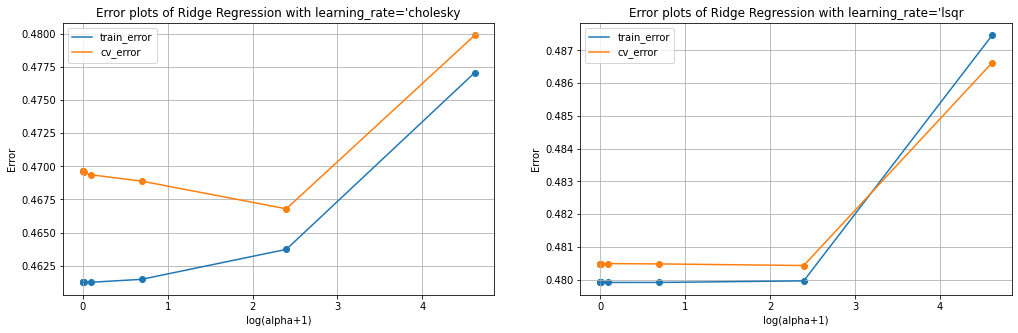

In [ ]:
alpha=[0.00001,0.0001,0.001,0.01,0.1,1,10,100]
alpha=[math.log(i+1) for i in alpha]
plt.figure(figsize=(17,5))
plt.subplot(1,2,1)
train_error_cholesky,cv_error_cholesky=return_result(gridsearchcv_ridge,'cholesky')
plt.plot(alpha,train_error_cholesky,label='train_error')
plt.scatter(alpha,train_error_cholesky)
plt.plot(alpha,cv_error_cholesky,label='cv_error')
plt.xlabel('log(alpha+1)')
plt.ylabel('Error')
plt.scatter(alpha,cv_error_cholesky)
plt.title("Error plots of Ridge Regression with learning_rate='cholesky")
plt.legend()
plt.grid()
plt.subplot(1,2,2)
train_error_lsqr,cv_error_lsqr=return_result(gridsearchcv_ridge,'lsqr')
plt.plot(alpha,train_error_lsqr,label='train_error')
plt.scatter(alpha,train_error_lsqr)
plt.plot(alpha,cv_error_lsqr,label='cv_error')
plt.scatter(alpha,cv_error_lsqr)
plt.title("Error plots of Ridge Regression with learning_rate='lsqr")
plt.xlabel("log(alpha+1)")
plt.ylabel("Error")
plt.legend()
plt.grid()
plt.show()

**Observations:**


    *   We trained the model for two learning rates. The error plot of learning rate with **cholesky** on the left and learning rate with **lsqr** on the right side of the plot.**
    *   learning rate with 'cholesky' is giving low error metric compared to 'lsqr' learning rate. But the train and cv error plots in 'lsqr' are more coinciding than the 'cholesky' plot.
    *   Since In the case of this case study error metric is important 'cholesky' be the best learning rate



In [ ]:
gridsearchcv_ridge.best_params_

{'alpha': 10, 'solver': 'cholesky'}

**Description:**


    *   Hyper parameter plays an important role in model predictions because using hyper parameter tuning we can protest our model from getting underfit and overfit
    *   From the Above Error plot we need to pick alpha value(hyper parameter) in such a way that both train and test error are low.
    *   With alpha=1 both the test error and train error are closer and are lesser than alpha>1. 
    *   With alpha=0.0001 the train error is low but test error is much higher than train error.
    *   Hence we will choose alpha=10 as the best hyperparameter in this case.



Ridge Regression with Best Hyper Parameters:

In [154]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=10,solver='cholesky',fit_intercept=False)
print("Model is fitting!!!")
ridge.fit(X_train, train_data['target'])
ytrain_cholesky_predict=ridge.predict(X_train)
ycv_cholesky_predict=ridge.predict(X_cv)
train_ = np.sqrt(mean_squared_error(train_data['target'], ytrain_cholesky_predict))
cv_=np.sqrt(mean_squared_error(cv_data['target'],ycv_cholesky_predict))
print("Ridge Regression with alpha = {} RMSLE on train is {} RMSLE on cv is {}".format(1,train_,cv_))

Model is fitting!!!
Ridge Regression with alpha = 1 RMSLE on train is 0.4632981770872124 RMSLE on cv is 0.46844142388371757


In [155]:
ycv_ridge=ridge.predict(X_cv)
print("R2 {}".format(r2_score(train_data['target'], ytrain_cholesky_predict)))

R2 0.8140628115366785


**Description:**


    *   Ridge Regression is a technique for analyzing multiple regression data that suffer from multicollinearity.
    *   It reduces the model complexity by coefficient shrinkage.
    *   It is also a linear model.
    *   This Regression model also have hyper parameters in it {alpha , solver}.
    *   After doing Tuning to the model we got 0.4667 RMSLE which is slightly better than LR and lasso regression model.



**SGD REGRESSOR**

In [ ]:
from sklearn.linear_model import SGDRegressor
sgd = SGDRegressor(loss='squared_loss', max_iter=200, penalty='l2',fit_intercept=False,l1_ratio=0.6)
params={'alpha':[0.000000001,0.00000001,0.00001,0.0001,0.001,0.01,0.1,0,1,10,100,1000],'learning_rate':['invscaling','adaptive']}
gridsearchcv=GridSearchCV(sgd,param_grid=params,return_train_score=True)
gridsearchcv.fit(X_train,train_data['target'])

GridSearchCV(estimator=SGDRegressor(fit_intercept=False, l1_ratio=0.6,
                                    loss='squared_loss', max_iter=200),
             param_grid={'alpha': [1e-09, 1e-08, 1e-05, 0.0001, 0.001, 0.01,
                                   0.1, 0, 1, 10, 100, 1000],
                         'learning_rate': ['invscaling', 'adaptive']},
             return_train_score=True)

with learning rate: adaptive
train_error:  [0.46258151544524667, 0.46258245482048427, 0.46483649432062113, 0.48016147635359874, 0.5205752819395818, 0.5917970847895279, 0.7255153319689673, 0.4625804956434685, 1.0049017176141175]
cv_error:  [0.4688558627790037, 0.4688619000720196, 0.4692822488228858, 0.4805051420009014, 0.5189131079049061, 0.5906065711592959, 0.7249848311406205, 0.4688377923404662, 1.0050139402008162]


with learning rate: invscaling
train_error:  [0.4893846551558464, 0.48954774037696247, 0.48973125711047344, 0.4929607195199796, 0.5213178486837378, 0.5926636632267787, 0.7266517284822288, 0.4894245397695104]
cv_error:  [0.4884044531500078, 0.48849486404927006, 0.48871279763132197, 0.4917611240507121, 0.5195797694682748, 0.5915081361184699, 0.7261611151478855, 0.48838273951167877]




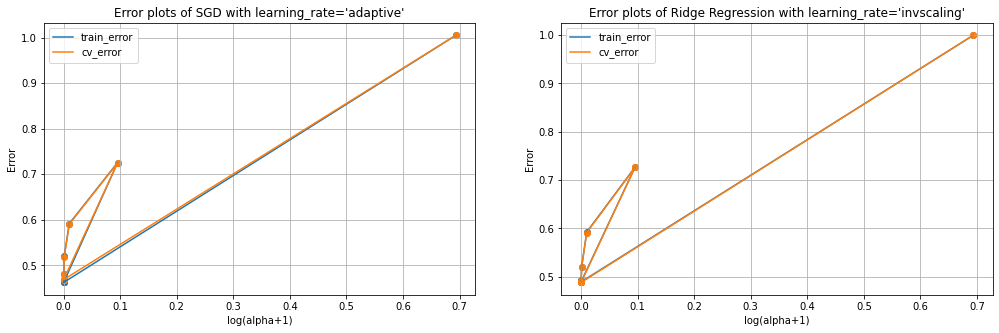

In [ ]:
alpha=[0.000000001,0.00000001,0.00001,0.0001,0.001,0.01,0.1,0,1]
alpha=[math.log(i+1) for i in alpha]
plt.figure(figsize=(17,5))
plt.subplot(1,2,1)
train_error_adaptive,cv_error_adaptive=return_result(gridsearchcv,'adaptive')
plt.plot(alpha,train_error_adaptive,label='train_error')
plt.scatter(alpha,train_error_adaptive)
plt.plot(alpha,cv_error_adaptive,label='cv_error')
plt.xlabel('log(alpha+1)')
plt.ylabel('Error')
plt.scatter(alpha,cv_error_adaptive)
plt.title("Error plots of SGD with learning_rate='adaptive'")
plt.legend()
plt.grid()
plt.subplot(1,2,2)
train_error_inv,cv_error_inv=return_result(gridsearchcv,'invscaling')
plt.plot(alpha,train_error_inv,label='train_error')
plt.scatter(alpha,train_error_inv)
plt.plot(alpha,cv_error_inv,label='cv_error')
plt.scatter(alpha,cv_error_inv)
plt.title("Error plots of SGD with learning_rate='invscaling'")
plt.xlabel("log(alpha+1)")
plt.ylabel("Error")
plt.legend()
plt.grid()
plt.show()

**Observations:**


    *   Like As in ridge regression here also we have two learning rates adaptive and invscaling.
    *   In both of the case train and cv are coinciding hence it is more stronger to say that the model is not overfitting.
    *   In the left plot the error is going decreased slightly compared to the error plot on the right side.



In [ ]:
gridsearchcv.best_params_

{'alpha': 1e-09, 'learning_rate': 'adaptive}


Schocatsic gradient regressor with best hyper parameters:

In [156]:
from sklearn.linear_model import SGDRegressor
sgd = SGDRegressor(alpha=1e-09,loss='squared_loss',learning_rate='adaptive', max_iter=200, penalty='l2',fit_intercept=False,l1_ratio=0.6)
sgd.fit(X_train, train_data['target'])
ytrain_predict=sgd.predict(X_train)
ycv_predict=sgd.predict(X_cv)
train_ = np.sqrt(mean_squared_error(train_data['target'], ytrain_predict))
cv_=np.sqrt(mean_squared_error(cv_data['target'],ycv_predict))
print("SGD Regression with alpha = {} RMSLE on train is {} RMSLE on cv is {}".format(1e-09,train_,cv_))

SGD Regression with alpha = 1e-09 RMSLE on train is 0.4621547384940508 RMSLE on cv is 0.4684980650112333


In [157]:
print("R2_score {}".format(r2_score(train_data['target'], ytrain_predict)))

R2_score 0.8159654778112444


**Description:**


    *   Stochastic Gradient Descent (SGD) is a simple yet very efficient approach to discriminative learning of linear classifiers under convex loss functions such as (linear)
    *   the gradient of the loss is estimated each sample at a time and the model is updated along the way with a decreasing strength schedule i.e.. Learning rate.
    *   After trying learning_rate with adaptive nature we got 0.4688 RMSLE on cv data which is slighly better than the above linear models.



**Boosting Models:**

**LGBM Regressor**

In [ ]:
params={'learning_rate':[0.1,0.3,0.5,0.6],'max_depth':[5,8,12,15],'n_estimators':[50,100,150,200],'num_leaves':[15,25,50,75],'boosting_type':['gbdt']}
lgbm_params={'sub_sample':0.9,'colsample_bytree':0.8,'min_child_samples':50,'objective':'regression'}
lgbm_regressor=LGBMRegressor(**lgbm_params)
gridsearchcv=GridSearchCV(lgbm_regressor,param_grid=params,n_jobs=-1,cv=3,verbose=1)
gridsearchcv.fit(X_train,train_data['target'],early_stopping_rounds=100,verbose=True)

Fitting 3 folds for each of 16 candidates, totalling 576 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 37.4min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 115.3min
[Parallel(n_jobs=-1)]: Done 576 taks       | elapsed: 126min


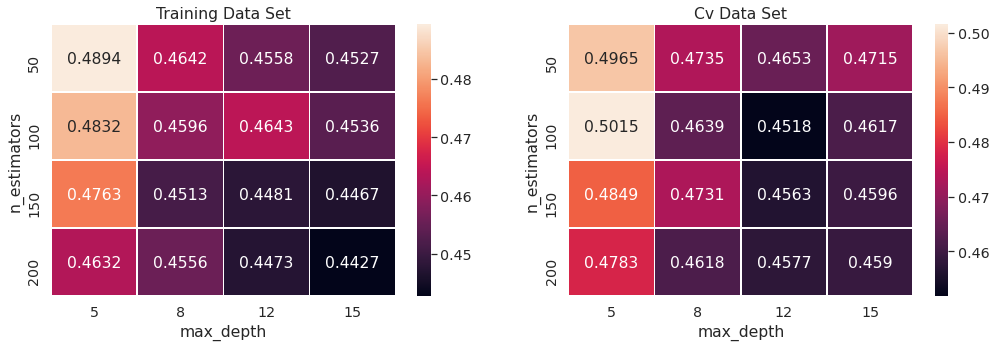

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(17,5)) 
sns.set(font_scale=1.3) 
data=pd.DataFrame(gridsearchcv.cv_results_).groupby(['param_min_samples_split','param_max_depth']).max().unstack()[['mean_train_score','mean_test_score']] 
sns.heatmap(data.mean_train_score,annot=True,linewidths=0.7,fmt='.4g',ax=ax[0],square=False,yticklabels=['50','100','150','200'])
ax[0].set_title("Training Data Set") 
ax[0].set_xlabel('max_depth')
ax[0].set_ylabel('n_estimators')
sns.heatmap(data.mean_test_score,annot=True,linewidths=.7,fmt='.4g',ax=ax[1],square=False,yticklabels=['50','100','150','200'])
ax[1].set_title("Cv Data Set")
ax[1].set_xlabel('max_depth')
ax[1].set_ylabel("n_estimators")
plt.show()

**Observations:**


    *   Heat maps can be used to represent the 2D data.
    *   we can see that the lgbm worked well with max_depth: 15 and n_estimators: 200.
    *   Compared to all the above ML models lgbm is good working with this data giving 0.4427 on train data and 0.4590 on cv data.



In [ ]:
gridsearchcv.best_params_

{'learning_rate': 0.1, 'max_depth: 15, 'n_estimators: 200', 'num_leaves: 75', 'boosting_type': 'gbdt'}


In [158]:
from lightgbm import LGBMRegressor
params={'learning_rate':[0.1],'max_depth':[15],'n_estimators':[200],'num_leaves':[75],'boosting_type':['gbdt']}
lgbm_regressor=LGBMRegressor(learning_rate=0.5,max_depth=8,n_estimators=500,num_leaves=80,boosting_type='gbdt',sub_sample=0.9,colsample_bytree=0.8,min_child_samples=50)
lgbm_regressor.fit(X_train,train_data['target'])

[LightGBM] [Warning] Unknown parameter: sub_sample


LGBMRegressor(colsample_bytree=0.8, learning_rate=0.5, max_depth=8,
              min_child_samples=50, n_estimators=500, num_leaves=80,
              sub_sample=0.9)

In [ ]:
ytrain_predict=lgbm_regressor.predict(X_train)
ycv_predict=lgbm_regressor.predict(X_cv)
training = np.sqrt(mean_squared_error(train_data['target'], ytrain_predict))
cving=np.sqrt(mean_squared_error(cv_data['target'],ycv_predict))
print("RMSLE of train is {} RMSLE of test is {}".format(training,cving))
print("R2_score {}".format(r2_score(train_data['target'], ytrain_predict)))

RMSLE of train is 0.4388697186380185 RMSLE of test is 0.45743735417468184
R2_score 0.8536886875252024


**Description:**


    *   Light GBM is a fast, distributed, high-performance gradient boosting framework based on decision tree algorithm.
    *   Faster training speed and higher efficiency than the other models we trained on the dataset.
    *   We can see that it occupies less RAM.
    *   It is supporting Parallel learning and it is compatible to higher datasets.
    *   It has the better performance than any other model we trained.After training the LGBM model we get 0.4590 RMSLE on cv data.Which is far better than other models.